In [1]:
# Importing necessary packages
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
# Machine learning libraries:# Machi 
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_predict

%matplotlib inline

In [2]:
#Reading data into dataframe
file_name = 'D:\\Springboard_Capstone2\\CapstoneDataset\\NewData\\YouTubeDataSet.csv'
df=pd.read_csv(file_name, encoding='utf-8')
df = df.dropna()
df.head()

,video_id,trending_date,title_description,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,title
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22.0,2017-11-13T17:13:01.000Z,SHANtell martin,748374.0,57527.0,2966.0,15954.0,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,People & Blogs
1,0mlNzVSJrT0,17.14.11,Me-O Cats Commercial,Nobrand,22.0,2017-04-21T06:47:32.000Z,"cute|""cats""|""thai""|""eggs""",98966.0,2486.0,184.0,532.0,https://i.ytimg.com/vi/0mlNzVSJrT0/default.jpg,False,False,False,Kittens come out of the eggs in a Thai commerc...,People & Blogs
2,STI2fI7sKMo,17.14.11,"AFFAIRS, EX BOYFRIENDS, $18MILLION NET WORTH -...",Shawn Johnson East,22.0,2017-11-11T15:00:03.000Z,"shawn johnson|""andrew east""|""shawn east""|""shaw...",321053.0,4451.0,1772.0,895.0,https://i.ytimg.com/vi/STI2fI7sKMo/default.jpg,False,False,False,Subscribe for weekly videos ▶ http://bit.ly/sj...,People & Blogs
3,KODzih-pYlU,17.14.11,BLIND(folded) CAKE DECORATING CONTEST (with Mo...,Grace Helbig,22.0,2017-11-11T18:08:04.000Z,"itsgrace|""funny""|""comedy""|""vlog""|""grace""|""helb...",197062.0,7250.0,217.0,456.0,https://i.ytimg.com/vi/KODzih-pYlU/default.jpg,False,False,False,Molly is an god damn amazing human and she cha...,People & Blogs
4,8mhTWqWlQzU,17.14.11,Wearing Online Dollar Store Makeup For A Week,Safiya Nygaard,22.0,2017-11-11T01:19:33.000Z,wearing online dollar store makeup for a week|...,2744430.0,115426.0,1110.0,6541.0,https://i.ytimg.com/vi/8mhTWqWlQzU/default.jpg,False,False,False,I found this online dollar store called ShopMi...,People & Blogs


#### The Numerical Features such as Views, Comment Count, Likes and Dislikes are highly correlated as obeserved in the Visualization section . Hence in my opinion I shall use only one Numerical Variable in our Training Data i.e., views

##### Keeping the numerical features of the dataset on one side. This numerical feature will be concatenated with the training set once the textual data has been tokenized.

In [3]:
# Keeping the numerical features of the dataset on one side. 
# This numerical feature will be concatenated with the training set once the textual data has been tokenized.
Statistics = df[['views']]
Statistics.shape

(40291, 1)

##### Converting the textual data into list format in order to make it ready for tokenization

In [4]:
# Converting the textual data (feature data) and video title (Label) into list format in order to make it ready for tokenization 
corpus = list(df['title_description'])
labels = list(df['title'])

##### Converting feature set int array format. I shall later pass this array as an argument to a function that will extract the theme from the textual data in the form of tokenized words.

In [5]:
# Converting feature set int array format. I shall later pass this array as an argument to a function that will extract 
# the theme from the textual data in the form of tokenized words.
corpus = np.array(corpus)

##### For the convinience of clear understanding I am representing the Feature set and Label set into a single DataFrame. 

In [6]:
# For my convinience of understanding I am representing the Feature set and Label set into a single DataFrame. 
corpus_df = pd.DataFrame({'Document': corpus, 
                          'Category': labels})
corpus_df = corpus_df[['Document', 'Category']]
corpus_df.head()

,Document,Category
0,WE WANT TO TALK ABOUT OUR MARRIAGE,People & Blogs
1,Me-O Cats Commercial,People & Blogs
2,"AFFAIRS, EX BOYFRIENDS, $18MILLION NET WORTH -...",People & Blogs
3,BLIND(folded) CAKE DECORATING CONTEST (with Mo...,People & Blogs
4,Wearing Online Dollar Store Makeup For A Week,People & Blogs


##### Following is a python function that removes unwanted characters in order to extract the theme of the textual data. Next we shall pass our textual data to this function in order to extract the theme.  

In [7]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)

text = normalize_corpus(corpus)
text

array(['want talk marriage', 'meo cats commercial',
       'affairs ex boyfriends million net worth google us shawn andrew',
       ..., 'game zones se isle van gundy',
       'game zones se isle van gundy', 'game zones se isle van gundy'],
      dtype='<U92')

##### The above represents the tokenized words or themes in array format, that have been extracted from textual description. 

### Vectorizing the tokenized words from array into Sparse Matrix format so that it can be fit into Classification model

In [8]:
# Vectorizing the tokenized words from array into Sparse Matrix format so that it can be fit into Classification model
vectorizer = CountVectorizer(min_df=0)
X = vectorizer.fit_transform(text)
X = X.tocsc()  # some versions of sklearn return COO format

### Checking the shape of the Sparse Matrix to ensure we have not lost any data

In [9]:
# Checking the shape of the Sparse Matrix to ensure we have not lost any data
X.shape

(40291, 10063)

##### Converting the Sparse Matrix into DataFrame so that we can combine it with video statistics feature set in order to build our Final Training Dataset

In [10]:
# Converting the Sparse Matrix into DataFrame so that we can combine it with video statistics feature set in 
# order to build our Final Training Dataset
A=pd.DataFrame(X.todense())

#### Concatenating Presprocessed Textual data with video statistics feature set in order to build our Final Training Dataset

In [11]:
# Concatenating Presprocessed Textual data with video statistics feature set in order to build our Final Training Dataset
U = pd.concat([Statistics.reset_index(drop=True), A.reset_index(drop=True)], axis=1)

#### Recheking the shape of our Training Data in order to confirm after concatenation no data has been lost.

In [12]:
U.shape

(40291, 10064)

### Preprocessing the Label column into a format that is suitable for fitting into our Classification Model

In [13]:
# Preprocessing the Label column into a format that is suitable for fitting into our Classification Model
mymap = {'People & Blogs':1, 'Entertainment':2, 'Comedy':3, 'Science & Technology':4, 'Film & Animation':5,'News & Politics':6,'Sports':7,'Music':8,'Pets & Animals':9,'Education':10,'Howto & Style':11,'Autos & Vehicles':12,'Travel & Events':13,'Gaming':14,'Nonprofits & Activism':15,'Shows':16}

label=df[['title']].applymap(lambda s: mymap.get(s) if s in mymap else s)

y = label.values.astype(np.int)

### Applying MultinomialNB Machine Learning Algorithms:

##### I have randomly chosen a set of Alpha values that I shall fit into my model and then see which of the values yield the highest accuracy.

In [14]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.model_selection import train_test_split

#I have randomly chosen a set of Alpha values that I shall fit into my model and 
#then see which of the values yield the highest accuracy  
#the grid of parameters to search over
alphas = [.1, 1, 5, 10, 50]

#### Splitting the Dataset into Training and Testing set 

In [15]:
# Splitting the Dataset into Training and Testing set
X_train,X_test,Y_train,Y_test = train_test_split(U,y,test_size=0.3,random_state=42)

In [16]:
# Define train_and_predict()
def train_and_predict(alpha):
    # Instantiate the classifier: nb_classifier
    nb_classifier = MultinomialNB(alpha=alpha)
    # Fit to the training data
    nb_classifier.fit(X_train,Y_train)
    # Predict the labels: pred
    pred = nb_classifier.predict(X_test)
    # Compute accuracy: score
    score = metrics.accuracy_score(Y_test,pred)
    return score

# Iterate over the alphas and print the corresponding score
for alpha in alphas:
    print('Alpha: ', alpha)
    print('Score: ', train_and_predict(alpha))
    print()

Alpha:  0.1


C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score:  0.8385175380542687

Alpha:  1
Score:  0.689692256783587

Alpha:  5
Score:  0.4737756452680344

Alpha:  10
Score:  0.3834381204500331

Alpha:  50
Score:  0.21757114493712773



##### Our model displays best accuracy of 83% at Alpha = 0.1 

### Also evaluating the Precision and Recall metric for a our training data

In [17]:
# Instantiate the classifier: nb_classifier
nb_classifier = MultinomialNB(alpha=0.1)
# Fit to the training data
nb_classifier.fit(X_train,Y_train)
# Predict the labels: pred
pred = nb_classifier.predict(X_test)


C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [18]:
# Machine learning pipelines
pipe_NB = make_pipeline(MultinomialNB())

In [19]:
# Compute predicted y's (y_hat)
predicted_NB = cross_val_predict(pipe_NB, X, y, cv=3, n_jobs=-1)

In [20]:
# Classification tables

print("Multinomial Naive Bayes:") 
print(classification_report(y, predicted_NB)) 
print('\n')

Multinomial Naive Bayes:
             precision    recall  f1-score   support

          1       0.23      0.23      0.23      3061
          2       0.55      0.48      0.51      9819
          3       0.42      0.38      0.40      3435
          4       0.37      0.45      0.41      2361
          5       0.48      0.55      0.51      2340
          6       0.53      0.51      0.52      2409
          7       0.62      0.72      0.67      2060
          8       0.77      0.78      0.77      6434
          9       0.39      0.46      0.42       916
         10       0.31      0.27      0.29      1642
         11       0.53      0.62      0.57      4132
         12       0.30      0.28      0.29       379
         13       0.48      0.39      0.43       402
         14       0.49      0.43      0.45       791
         15       0.65      0.21      0.31        53
         16       0.69      0.72      0.71        57

avg / total       0.52      0.52      0.52     40291





##### The Precision and Recall Rate give us an idea about the discriminative abitity of our classifier. In this case our Precision and Recall rate happen to be 0.52

## Generating the Confusion Matrix:

In [21]:
from sklearn import metrics
import seaborn as sns

In [22]:
score=[]
# Instantiate the classifier: nb_classifier
nb_classifier = MultinomialNB(alpha=0.1)
# Fit to the training data
nb_classifier.fit(X_train,Y_train)
# Predict the labels: pred
pred = nb_classifier.predict(X_test)
# Compute accuracy: score
score.append(metrics.accuracy_score(Y_test,pred))

C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [23]:
cm = metrics.confusion_matrix(Y_test, pred)

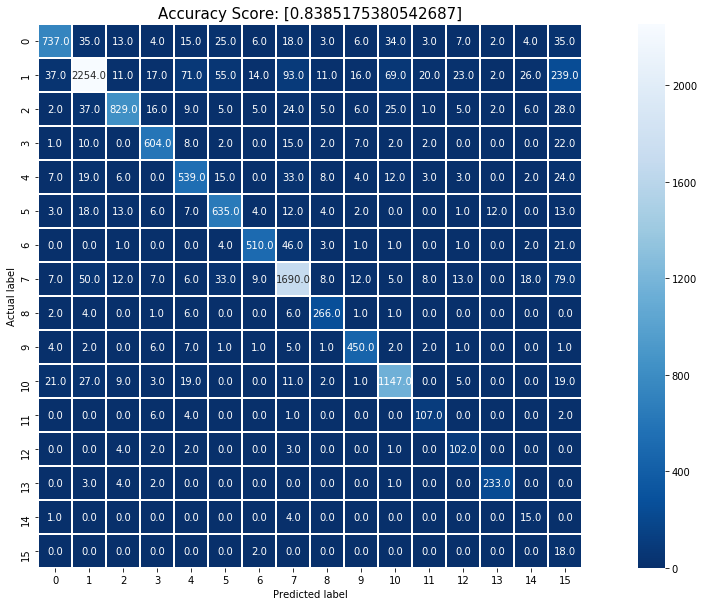

In [24]:
plt.figure(figsize=(20,10))
sns.heatmap(cm, annot=True, fmt=".1f", linewidths=1.0, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

## Checking the accuracy score when only the tokenized words are used as feature set

In [54]:
# Splitting the Dataset into Training and Testing set
X_train,X_test,Y_train,Y_test = train_test_split(X,y,test_size=0.3,random_state=42)

# Define train_and_predict()
def train_and_predict(alpha):
    # Instantiate the classifier: nb_classifier
    nb_classifier = MultinomialNB(alpha=alpha)
    # Fit to the training data
    nb_classifier.fit(X_train,Y_train)
    # Predict the labels: pred
    pred = nb_classifier.predict(X_test)
    # Compute accuracy: score
    score = metrics.accuracy_score(Y_test,pred)
    return score

# Iterate over the alphas and print the corresponding score
for alpha in alphas:
    print('Alpha: ', alpha)
    print('Score: ', train_and_predict(alpha))
    print()


Alpha:  0.1
Score:  0.9268696227663799

Alpha:  1
Score:  0.8899735274652548

Alpha:  5


C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Score:  0.7897088021178028

Alpha:  10
Score:  0.7217902051621443

Alpha:  50
Score:  0.5210953011250827



In [55]:
# Instantiate the classifier: nb_classifier
nb_classifier = MultinomialNB(alpha=0.1)
# Fit to the training data
nb_classifier.fit(X_train,Y_train)
# Predict the labels: pred
pred = nb_classifier.predict(X_test)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [56]:
# Machine learning pipelines
pipe_NB = make_pipeline(MultinomialNB())

In [57]:
# Compute predicted y's (y_hat)
predicted_NB = cross_val_predict(pipe_NB, X, y, cv=3, n_jobs=-1)

In [58]:
# Classification tables

print("Multinomial Naive Bayes:") 
print(classification_report(y, predicted_NB)) 
print('\n')

Multinomial Naive Bayes:
             precision    recall  f1-score   support

          1       0.23      0.23      0.23      3061
          2       0.55      0.48      0.51      9819
          3       0.42      0.38      0.40      3435
          4       0.37      0.45      0.41      2361
          5       0.48      0.55      0.51      2340
          6       0.53      0.51      0.52      2409
          7       0.62      0.72      0.67      2060
          8       0.77      0.78      0.77      6434
          9       0.39      0.46      0.42       916
         10       0.31      0.27      0.29      1642
         11       0.53      0.62      0.57      4132
         12       0.30      0.28      0.29       379
         13       0.48      0.39      0.43       402
         14       0.49      0.43      0.45       791
         15       0.65      0.21      0.31        53
         16       0.69      0.72      0.71        57

avg / total       0.52      0.52      0.52     40291





##### Even after the accuracy has increased, the Precision and Recall value seem to have remained the same.

## Creating a Confusion Matrix:

In [59]:
from sklearn import metrics
import seaborn as sns

In [60]:
score=[]
# Instantiate the classifier: nb_classifier
nb_classifier = MultinomialNB(alpha=0.1)
# Fit to the training data
nb_classifier.fit(X_train,Y_train)
# Predict the labels: pred
pred = nb_classifier.predict(X_test)
# Compute accuracy: score
score.append(metrics.accuracy_score(Y_test,pred))

C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [62]:
cm = metrics.confusion_matrix(Y_test, pred)

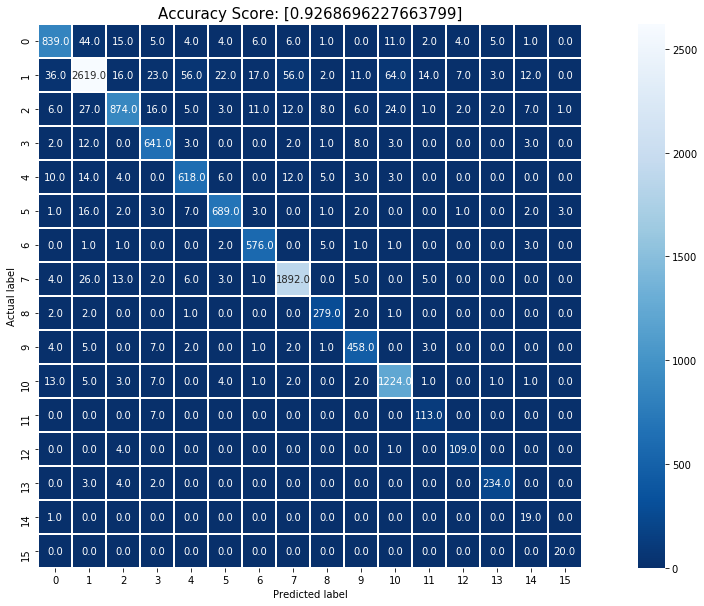

In [72]:
plt.figure(figsize=(20,10))
sns.heatmap(cm, annot=True, fmt=".1f", linewidths=1.0, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

###### This particular model where no numerical features have not been utilized displays its best accuracy of 92% when Alpha = 0.1

## Checking the performance of other Classification Machine Learning Algorithms:

### Trying out Logistic Regression:

In [106]:
# split X and y into training and testing sets
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [107]:
# train a logistic regression model on the training set
from sklearn.linear_model import LogisticRegression

# instantiate model
logreg = LogisticRegression()

# fit model
logreg.fit(X_train, y_train)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [108]:
# Predict the labels: pred
pred = logreg.predict(X_test)

In [111]:
# calculate accuracy
from sklearn import metrics
print(metrics.accuracy_score(y_test, pred))

0.965452198947682


## Final Story:

Continuous Numerical features such as Views, Likes, Dislikes, Comment Count are not very helpful features to classify videos based on their themes. The reason is because the number of views that a particular video recieves is independent of the theme or category of the video.Irrespective of its theme/category the video may get higher views based on how well it appeals to its target audience. Hence, it is not necessary that particular categories of videos always get very high views. This is the possible reason why the accuracy dropped.
